<a href="https://colab.research.google.com/github/tikendraw/language-translation-model/blob/main/language_translation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Language Translation Model (English to Hindi)


---




In [1]:
import os, sys
if 'google.colab' in sys.modules:
    
    ! git clone https://github.com/tikendraw/language-translation-model.git 
    os.chdir('language-translation-model') 
    print(os.getcwd())

Cloning into 'language-translation-model'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 22 (delta 7), reused 11 (delta 3), pack-reused 0
Unpacking objects: 100% (22/22), 376.54 KiB | 3.73 MiB/s, done.
/content/language-translation-model


In [2]:
# Dependencies
! pip install polars -q
import polars as pd
from datetime import datetime
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model , optimizers
from tensorflow.keras.layers import Attention,GRU, LSTM, Bidirectional, Dense, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, AveragePooling1D, Dropout, concatenate, Concatenate

import seaborn as sns
import matplotlib.pyplot as plt

!pip install tensorflow_hub -q
import tensorflow_hub as hub
import os
import re
import json
from sklearn.model_selection import train_test_split

print('Tf version: ',tf.__version__)
print('GPU: ', is_gpu:=len(tf.config.list_physical_devices('GPU')))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["TFHUB_CACHE_DIR"] = './tmp/tfhub'

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
None
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""
if is_gpu:
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
    config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(physical_devices)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 66.7 MB/s eta 0:00:00
Tf version:  2.11.0
GPU:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
dataset_url = 'http://www.manythings.org/anki/hin-eng.zip'

In [4]:
# # # Download the dataset
# if 'google.colab' in sys.modules:
#     # donwload
#     !wget $dataset_url -P dataset

#     # # Unzip the downloaded file
#     !unzip ./dataset/hin-eng.zip -d ./dataset

#     # # Show size
#     !du -h  ./dataset

# Reading the data

In [5]:
df = pd.read_csv('./dataset/hin.txt', sep = '\t', new_columns = ['english', 'hindi', 'somethingelse'])[['english','hindi']]

In [6]:
df.shape

(2908, 2)

In [7]:
df.sample(10)

english,hindi
str,str
"""Duck!""","""झुको!"""
"""Mother and I a...","""मम्मी और मैं क..."
"""Do you jog eve...","""क्या आप हर दिन..."
"""I have a heada...","""मुझे सिरदर्द ह..."
"""Classical musi...","""मुझे शास्त्रीय..."
"""Tom may invite...","""टॉम हमें आमंत्..."
"""She wanted to ...","""वह अपने बाल कट..."
"""He's sleeping ...","""वह बच्चे की तर..."
"""He came runnin...","""वह भागते हुए आ..."


In [8]:
from sklearn.model_selection import train_test_split

In [9]:
UNITS = 32
EMBEDDING_DIMS = 16
BATCH_SIZE = 32

# Prepare the data `tf.data`

In [10]:
# Split the data for train and val
train_df, val_df = train_test_split(df, test_size = .02, random_state = 4 )

In [11]:
print('train shape: ', train_df.shape)
print('val shape: ', val_df.shape)

train shape:  (2849, 2)
val shape:  (59, 2)


In [12]:
BUFFER_SIZE = 2000

In [13]:
train_ds = tf.data.Dataset.from_tensor_slices((train_df['english'].to_list(), train_df['hindi'].to_list())).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((val_df['english'].to_list(), val_df['hindi'].to_list())).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [14]:
len(train_ds)

90

In [15]:

# preprocessing text
def tf_lower_and_split_punct_en(text):
    # Split accented characters.
    # text = tf.text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '[.?!,¿|]', r' \0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')

    return text



# preprocessing text
def tf_lower_and_split_punct_hi(text):
    text = tf.strings.regex_replace(text, '[.?!,¿|]', r' \0 ')
    text = tf.strings.strip(text)
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [16]:
some_hindi_text = 'उन्होंने मेरी का| मज़ाक उड़ाया'
print(some_hindi_text)
b= tf_lower_and_split_punct_hi(some_hindi_text)
print(b)
print(b.numpy().decode())
del(b)

उन्होंने मेरी का| मज़ाक उड़ाया
tf.Tensor(b'[START] \xe0\xa4\x89\xe0\xa4\xa8\xe0\xa5\x8d\xe0\xa4\xb9\xe0\xa5\x8b\xe0\xa4\x82\xe0\xa4\xa8\xe0\xa5\x87 \xe0\xa4\xae\xe0\xa5\x87\xe0\xa4\xb0\xe0\xa5\x80 \xe0\xa4\x95\xe0\xa4\xbe |  \xe0\xa4\xae\xe0\xa4\x9c\xe0\xa4\xbc\xe0\xa4\xbe\xe0\xa4\x95 \xe0\xa4\x89\xe0\xa4\xa1\xe0\xa4\xbc\xe0\xa4\xbe\xe0\xa4\xaf\xe0\xa4\xbe [END]', shape=(), dtype=string)
[START] उन्होंने मेरी का |  मज़ाक उड़ाया [END]


In [17]:
for i, j in train_ds.take(1):
    print('i: ',i)
    print('j: ', j)
    # print('j decoded: ',j.numpy().decode())

i:  tf.Tensor(
[b'Smoking will do you a lot of harm.'
 b'He will write for hours at a time.' b'Tom is my idol.' b'Go away!'
 b'I was born in 1960.' b'What do you like to do?'
 b'Father objected to my going to the mountain alone.'
 b"It's already nine o'clock." b"Nobody's around." b'We went shopping.'
 b'His new book is going to come out next month.'
 b'He seemed surprised by my ignorance.'
 b"I don't think that anyone noticed what we did." b'He likes oranges.'
 b'It is already eleven.' b'Is your father a teacher?'
 b'She cut the cake into six pieces and gave one to each of the children.'
 b'Have you ever failed an exam?'
 b'He left his parents when he was eight years old.'
 b'She plays tennis very well.' b'I am reading a book.'
 b'I was caught in a shower and was drenched to the skin.'
 b'This machine is superior in quality to that one.'
 b'Half of the apples are rotten.'
 b"I'm going to go buy some materials today." b'The house was in flames.'
 b'He wanted to buy the book.' b"I'd like

# Text Vectorization


In [18]:
output_sequence_length = 200

In [19]:
eng_vectorizer = tf.keras.layers.TextVectorization(standardize = tf_lower_and_split_punct_en, output_sequence_length= output_sequence_length)
hin_vectorizer = tf.keras.layers.TextVectorization(standardize = tf_lower_and_split_punct_hi, output_sequence_length= output_sequence_length+1 )

In [20]:
# Adapting to textvectorizer
eng_vectorizer.adapt(train_ds.map(lambda x, y: x))
hin_vectorizer.adapt(train_ds.map(lambda x, y: y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [21]:
max_token_english = len(eng_vectorizer.get_vocabulary())
max_token_hindi = len(hin_vectorizer.get_vocabulary())

print('Maxtokens:')
print( 'English : ', max_token_english)
print('Hindi: ', max_token_hindi)

Maxtokens:
English :  2359
Hindi:  3016


In [22]:
print('Text: ',some_hindi_text)
print('\nEncoded text: ,')
hin_vectorizer(some_hindi_text)

Text:  उन्होंने मेरी का| मज़ाक उड़ाया

Encoded text: ,


<tf.Tensor: shape=(201,), dtype=int64, numpy=
array([   2,  173,   40,   20, 1446,  369,    1,    3,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

## Mapping Vectorizer to dataset

In [23]:
BATCH_SIZE = 32

In [24]:
def make_vec(x, y ):
    x, y = eng_vectorizer(x), hin_vectorizer(y)

    y_in = y[:,:-1]
    y_out = y[:,1:]
    return (x,y_in), y_out

In [25]:
train_ds = train_ds.map(make_vec) #.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(make_vec) # .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [26]:
for i,j in val_ds.take(1):
    print(i[1])
    print()
    print(j)
    break

tf.Tensor(
[[  2  39 332 ...   0   0   0]
 [  2   8 183 ...   0   0   0]
 [  2  11   8 ...   0   0   0]
 ...
 [  2  26 827 ...   0   0   0]
 [  2   9   1 ...   0   0   0]
 [  2   8 360 ...   0   0   0]], shape=(32, 200), dtype=int64)

tf.Tensor(
[[ 39 332  15 ...   0   0   0]
 [  8 183 141 ...   0   0   0]
 [ 11   8 168 ...   0   0   0]
 ...
 [ 26 827  20 ...   0   0   0]
 [  9   1  90 ...   0   0   0]
 [  8 360 949 ...   0   0   0]], shape=(32, 200), dtype=int64)


# Model

## Encoder

In [27]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, text_processor, units, embedding_dims = 32):
        super(Encoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.units = units
        # self.return_state = return_state
        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units, mask_zero=True)

        # The RNN layer processes those vectors sequentially.
        self.rnn = tf.keras.layers.Bidirectional(
            merge_mode='sum',
            layer=tf.keras.layers.LSTM(units, 
                                       return_sequences = True, 
                                       return_state = True,
                                       recurrent_initializer='glorot_uniform'))

    def call(self, x):

        # 2. The embedding layer looks up the embedding vector for each token.
        x = self.embedding(x)

        # 3. The GRU processes the sequence of embeddings.
        *x, state_h, state_c = self.rnn(x)
        tf.print('after encoder return sequence true: ',len(x) )
        state = [state_h, state_c]
    
        return x, state

    def convert_input(self, texts):
        texts = tf.convert_to_tensor(texts)
        if len(texts.shape) == 0:
            texts = tf.convert_to_tensor(texts)[tf.newaxis]
        context = self.text_processor(texts)
        context = self(context)
        return context

## Attention

In [28]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x, context):

        attn_output, attn_scores = self.mha(
            query=x,
            value=context,
            return_attention_scores=True)

        # Cache the attention scores for plotting later.
        attn_scores = tf.reduce_mean(attn_scores, axis=1)
        self.last_attention_weights = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

## Decoder

In [29]:
class Decoder(tf.keras.layers.Layer):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, text_processor, units, embedding_dims = 32):
        super(Decoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.word_to_id = tf.keras.layers.StringLookup(vocabulary=text_processor.get_vocabulary(), mask_token='', oov_token='[UNK]')
        self.id_to_word = tf.keras.layers.StringLookup(vocabulary=text_processor.get_vocabulary(), mask_token='', oov_token='[UNK]', invert=True)
        self.start_token = self.word_to_id('[START]')
        self.end_token = self.word_to_id('[END]')

        self.units = units


        # 1. The embedding layer converts token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units, mask_zero=True)

        # 2. The RNN keeps track of what's been generated so far.
        self.rnn = tf.keras.layers.LSTM(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

        # 3. The RNN output will be the query for the attention layer.
        self.attention = CrossAttention(units)

        # 4. This fully connected layer produces the logits for each
        # output token.
        self.output_layer = tf.keras.layers.Dense(self.vocab_size)

### Decoder call

In [30]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  

    # 1. Lookup the embeddings
    x = self.embedding(x)

    # 2. Process the target sequence.
    x = self.rnn(x, initial_state=state)
    tf.print('decoder output: ', len(x))
    # 3. Use the RNN output as the query for the attention over the context.
    x = self.attention(x, context)
    self.last_attention_weights = self.attention.last_attention_weights


    # Step 4. Generate logit predictions for the next token.
    logits = self.output_layer(x)

    if return_state:
        return logits, state
    else:
        return logits

In [31]:
@Decoder.add_method
def get_initial_state(self, context):
    batch_size = tf.shape(context)[0]
    start_tokens = tf.fill([batch_size, 1], self.start_token)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    embedded = self.embedding(start_tokens)
    return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [32]:
@Decoder.add_method
def tokens_to_text(self, tokens):
    words = self.id_to_word(tokens)
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
    result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
    return result

In [33]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
    logits, state = self(context, next_token, state = state, return_state=True) 

    if temperature == 0.0:
        next_token = tf.argmax(logits, axis=-1)
    else:
        logits = logits[:, -1, :]/temperature
        next_token = tf.random.categorical(logits, num_samples=1)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (next_token == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

    return next_token, done, state

In [34]:
# class Translator(tf.keras.Model):
#     @classmethod
#     def add_method(cls, fun):
#         setattr(cls, fun.__name__, fun)
#         return fun

#     def __init__(self, units, context_text_processor, target_text_processor):
#         super().__init__()
#         # Build the encoder and decoder
#         encoder = Encoder(context_text_processor, units)
#         decoder = Decoder(target_text_processor, units)

#         self.encoder = encoder
#         self.decoder = decoder
        

#     def call(self, inputs):
#         context, x = inputs
#         tf.print('Before encoder-decoder')
#         # tf.print('inputs : ',inputs.shape)
#         tf.print('context: ',context.shape)
#         tf.print('x      : ',x.shape)
#         context = self.encoder(context)
#         tf.print()
#         logits = self.decoder(context, x)
#         tf.print('--'*20)
#         tf.print('After encoder-decoder')
#         tf.print('context: ',context.shape)
#         tf.print('logits : ',logits.shape)
#     #TODO(b/250038731): remove this
#         try:
#           # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
#             del logits._keras_mask
#         except AttributeError:
#             pass

#         return logits

In [35]:
class Translator2(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, units, context_text_processor, target_text_processor):
        super().__init__()
        
        self.context_text_processor = context_text_processor
        self.target_text_processor = target_text_processor

        self.context_vocab_size = context_text_processor.vocabulary_size()
        self.target_vocab_size = target_text_processor.vocabulary_size()
        
        self.word_to_id = tf.keras.layers.StringLookup(vocabulary=target_text_processor.get_vocabulary(), mask_token='', oov_token='[UNK]')
        self.id_to_word = tf.keras.layers.StringLookup(vocabulary=target_text_processor.get_vocabulary(), mask_token='', oov_token='[UNK]', invert=True)
    
        self.units = units

        # The embedding layer converts tokens to vectors
        self.embedding1 = tf.keras.layers.Embedding(self.context_vocab_size, units, mask_zero=True)
        self.embedding2 = tf.keras.layers.Embedding(self.target_vocab_size, units, mask_zero=True)

        # The RNN layer processes those vectors sequentially.
        self.encoder = tf.keras.layers.Bidirectional(
            merge_mode='concat',
            layer=tf.keras.layers.GRU(units, 
                                       return_sequences = True, 
                                       return_state = True,
                                       recurrent_initializer='glorot_uniform'))
        
        self.decoder = tf.keras.layers.Bidirectional(
            merge_mode='concat',
            layer=tf.keras.layers.GRU(units, 
                                       return_sequences = True, 
                                       return_state = True,
                                       recurrent_initializer='glorot_uniform'))
        
        
        self.start_token = self.word_to_id('[START]')
        self.end_token = self.word_to_id('[END]')

        # 3. The RNN output will be the query for the attention layer.
        self.attention = CrossAttention(units)
        self.last_attention_weights = None
        # 4. This fully connected layer produces the logits for each
        # output token.
        self.output_layer = tf.keras.layers.Dense(self.target_vocab_size)
        
        self.encoder_state = None
    def call(self, X, y=None):
        context, que = X
        
        #Encoding
        # 1. embedding
        x = self.embedding1(context)
        # tf.print('after embedding: x shape: ',x.shape )
        encoder_context, enc_h, enc_c = self.encoder(x)
        self.encoder_state = [enc_h, enc_c]
        # tf.print('after encodeing: x shape: ',len(x) )

        # encoder_context, encoder_state = x
        #Decoding
        x = self.embedding2(que)
        decoder_context, decoder_state_h, decoder_state_c = self.decoder(x, initial_state=self.encoder_state)
        
        x = self.attention(decoder_context, encoder_context)
        # self.last_attention_weights = self.attention.last_attention_weights
        # tf.print('decoder context shape: ', len(decoder_context))
        # logits
        logits = self.output_layer(x)
            # tf.print('\n')
        #TODO(b/250038731): remove this
        try:
          # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
            del logits._keras_mask
        except AttributeError:
            pass

        return logits

In [36]:
@Translator2.add_method
def convert_input(self, texts):

    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
        texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.context_text_processor(texts)
    context = self(context)
    return context

In [37]:
@Translator2.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding2(start_tokens)
  context = self.decoder.get_initial_state(embedded)[0]
  return start_tokens, done, context 

In [38]:
@Translator2.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [39]:
@Translator2.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self.decoder(
    context, next_token,
    state = state,
    return_state=True) 
  
  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
  
  return next_token, done, state

In [57]:
@Translator2.add_method
def translate(self,
              texts,
              max_length=50,
              temperature=0.0):
  # Process the input texts
    context = self.convert_input(texts)
    batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
    tokens = []
    # attention_weights = []
    next_token, done, state = self.get_initial_state(context)

    for _ in range(max_length):
        # Generate the next token
        next_token, done, state = self.get_next_token(context, next_token, done,  state, temperature)

        # Collect the generated tokens
        tokens.append(next_token)
        # attention_weights.append(self.last_attention_weights)

        if tf.executing_eagerly() and tf.reduce_all(done):
            break

    # Stack the lists of tokens and attention weights.
    tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
    # self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

    result = self.decoder.tokens_to_text(tokens)
    return result

In [58]:
ss = model.translate(['She loves me'])
ss

ValueError: ignored

In [42]:
model = Translator2(UNITS, eng_vectorizer, hin_vectorizer)

In [43]:
#@title
# sample = train_df.sample(5)
# some_hindi_text = sample['hindi'].to_numpy()
# some_eng_text = sample['english'].to_numpy()

# print(some_hindi_text)
# print(some_eng_text)

# vectorized_eng_text = eng_vectorizer(some_eng_text)
# vectorized_eng_text[:,:10]

# vectorized_hindi_text = hin_vectorizer(some_hindi_text)
# vectorized_hindi_text[:,:10]

# vec_hindi_in = vectorized_hindi_text[:,:-1]
# vec_hindi_out = vectorized_hindi_text[:,1:]
# print(vec_hindi_in[:,:10])
# print()
# print(vec_hindi_out[:,:10])

# encoder = Encoder(eng_vectorizer, UNITS)
# # context_eng = encoder((vectorized_eng_text))

# new_tx = encoder.convert_input(['hey man'])

# # context_eng

# # decoder = Decoder(hin_vectorizer, UNITS)
# # logits = decoder(context_eng, vec_hindi_in)
# # logits.shape

In [44]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [45]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [46]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [47]:
# model.summary()

In [48]:
EPOCHS = 30
CKPT_DIR = './model_checkpoint'

In [49]:
model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(CKPT_DIR,  f"{datetime.now().strftime('%m:%d:%Y, %H:%M:%S')}"),
    monitor= 'loss',
    verbose= 0,
    save_best_only = True,
    save_weights_only = True,
    mode= 'auto',
    save_freq='epoch'
)

In [50]:
data_amount = 20

In [51]:
# tf.executing_eagerly(False)

history = model.fit(
    train_ds.repeat(), 
    epochs=EPOCHS,
    steps_per_epoch = int(data_amount*(len(train_ds)/EPOCHS)),

    validation_data=val_ds.repeat(),
    validation_steps = 5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor = 'masked_loss', patience=3),
    model_ckpt])

Epoch 1/30
60/60 [==============================] - 41s 254ms/step - loss: 6.7381 - masked_acc: 0.1199 - masked_loss: 6.7381 - val_loss: 6.1761 - val_masked_acc: 0.1210 - val_masked_loss: 6.1694
Epoch 2/30
60/60 [==============================] - 7s 123ms/step - loss: 5.7408 - masked_acc: 0.1472 - masked_loss: 5.7366 - val_loss: 5.5941 - val_masked_acc: 0.1976 - val_masked_loss: 5.5964
Epoch 3/30
60/60 [==============================] - 4s 70ms/step - loss: 5.0454 - masked_acc: 0.2503 - masked_loss: 5.0392 - val_loss: 4.9558 - val_masked_acc: 0.3056 - val_masked_loss: 4.9578
Epoch 4/30
60/60 [==============================] - 3s 55ms/step - loss: 4.2901 - masked_acc: 0.3585 - masked_loss: 4.2901 - val_loss: 4.3521 - val_masked_acc: 0.3768 - val_masked_loss: 4.3530
Epoch 5/30
60/60 [==============================] - 3s 56ms/step - loss: 3.6373 - masked_acc: 0.4384 - masked_loss: 3.6372 - val_loss: 3.8181 - val_masked_acc: 0.4346 - val_masked_loss: 3.8285
Epoch 6/30
60/60 [==============

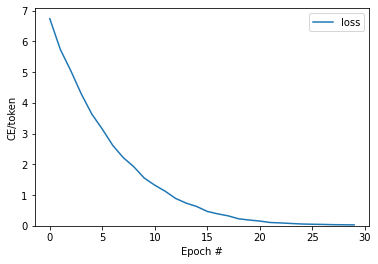

In [52]:
plt.plot(history.history['loss'], label='loss')
# plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

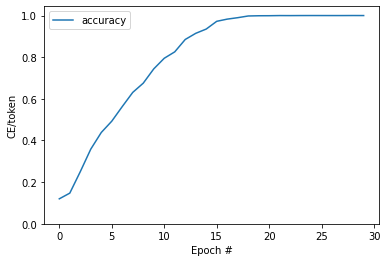

In [53]:
plt.plot(history.history['masked_acc'], label='accuracy')
# plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [ ]:
result = model.translate(['She loves me']) 
result[0].numpy().decode()

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.ylim([0, max(plt.ylim())])
plt.title('accuracy vs epochs')
plt.legend()